In [40]:
import sqlalchemy
import configparser
import pandas as pd
import numpy as np
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

### Retrieve Data from MySQL Workbench

In [2]:
config = configparser.ConfigParser()
config_file = '../config.ini'
config.read(config_file)
default = config['DEFAULT-SQLALCHEMY']
engine = sqlalchemy.create_engine('mysql+mysqlconnector://{0}:{1}@{2}/{3}'.
                                            format(default['DB_USER'], default['DB_PASSWORD'], 
                                                    default['DB_IP'], default['DB_DATABASE']))

In [3]:
query = """
select *
from
reddit_data
"""

df = pd.read_sql(query, engine)

df.head()

,title,selftext,category,subreddit,datetime
0,The reason I love alcohol at 18. It makes me f...,I,hot,mentalhealth\n,2023-10-08 07:21:22
1,Work-Related Anxiety/Depression,Lately I've been having some pretty serious an...,hot,mentalhealth\n,2023-10-08 05:30:05
2,Does anyone else feel like they don’t belong a...,It does not matter who is around me or who I a...,hot,mentalhealth\n,2023-10-08 03:31:24
3,Working in a supermarket is hell on earth.,I've worked in a supermarket for 4 years now. ...,hot,mentalhealth\n,2023-10-08 07:06:59
4,I feel like I’m not valid,TW: Mentions of abuse\n\nI don’t even remember...,hot,mentalhealth\n,2023-10-08 08:25:54


In [4]:
df = df[['title', 'selftext']]
df.head()

,title,selftext
0,The reason I love alcohol at 18. It makes me f...,I
1,Work-Related Anxiety/Depression,Lately I've been having some pretty serious an...
2,Does anyone else feel like they don’t belong a...,It does not matter who is around me or who I a...
3,Working in a supermarket is hell on earth.,I've worked in a supermarket for 4 years now. ...
4,I feel like I’m not valid,TW: Mentions of abuse\n\nI don’t even remember...


### Data Cleaning

In [5]:
# remove numbers in dataframe

df = df.replace('\d+', '', regex=True)
df.head()

,title,selftext
0,The reason I love alcohol at . It makes me fee...,I
1,Work-Related Anxiety/Depression,Lately I've been having some pretty serious an...
2,Does anyone else feel like they don’t belong a...,It does not matter who is around me or who I a...
3,Working in a supermarket is hell on earth.,I've worked in a supermarket for years now. P...
4,I feel like I’m not valid,TW: Mentions of abuse\n\nI don’t even remember...


In [6]:
# remove punctuations in dataframe
# edit some punctuations to space instead

df = df.replace('[.,]+', '', regex=True)
df = df.replace('[/]+', ' ', regex=True)
df.head()

,title,selftext
0,The reason I love alcohol at It makes me feel...,I
1,Work-Related Anxiety Depression,Lately I've been having some pretty serious an...
2,Does anyone else feel like they don’t belong a...,It does not matter who is around me or who I a...
3,Working in a supermarket is hell on earth,I've worked in a supermarket for years now Pr...
4,I feel like I’m not valid,TW: Mentions of abuse\n\nI don’t even remember...


In [7]:
# change all to lowercase in dataframe

df = df.apply(lambda x: x.astype(str).str.lower())
df.head()

,title,selftext
0,the reason i love alcohol at it makes me feel...,i
1,work-related anxiety depression,lately i've been having some pretty serious an...
2,does anyone else feel like they don’t belong a...,it does not matter who is around me or who i a...
3,working in a supermarket is hell on earth,i've worked in a supermarket for years now pr...
4,i feel like i’m not valid,tw: mentions of abuse\n\ni don’t even remember...


In [8]:
# drop any values in the dataframe

print("Original Data: {}".format(df.shape))

df = df.dropna()

print("New Data: {}".format(df.shape))
df.head()

Original Data: (14805, 2)
New Data: (14805, 2)


,title,selftext
0,the reason i love alcohol at it makes me feel...,i
1,work-related anxiety depression,lately i've been having some pretty serious an...
2,does anyone else feel like they don’t belong a...,it does not matter who is around me or who i a...
3,working in a supermarket is hell on earth,i've worked in a supermarket for years now pr...
4,i feel like i’m not valid,tw: mentions of abuse\n\ni don’t even remember...


In [9]:
# combine selftext to title

df = df.stack().reset_index(level=1, drop=True).to_frame('title').reset_index(drop=True)
df = df.rename(columns={'title':'text'})
df

,text
0,the reason i love alcohol at it makes me feel...
1,i
2,work-related anxiety depression
3,lately i've been having some pretty serious an...
4,does anyone else feel like they don’t belong a...
...,...
29605,i (f) am in college i have a group of friends ...
29606,what should i do?
29607,please can somebody help me? i really don't kn...
29608,team co-captain


In [10]:
# return df with titile and selftext not single word

mask = (df['text'].str.len() == 1)
df = df[~mask].reset_index(drop=True)

print("New Data: {}".format(df.shape))
df.head()

New Data: (29587, 1)


,text
0,the reason i love alcohol at it makes me feel...
1,work-related anxiety depression
2,lately i've been having some pretty serious an...
3,does anyone else feel like they don’t belong a...
4,it does not matter who is around me or who i a...


In [11]:
# convert short forms to full terms e.g. can't --> cannot

def contraction(s):
    s = re.sub(r"doesn't", "does not", s)
    s = re.sub(r"don't", "do not", s)
    s = re.sub(r"didn't", "did not", s)
    s = re.sub(r"won't", "will not", s)
    s = re.sub(r"wouldn't", "would not", s)
    s = re.sub(r"haven't", "have not", s)
    s = re.sub(r"hasn't", "has not", s)
    s = re.sub(r"hadn't", "had not", s)
    s = re.sub(r"shan't", "shall not", s)
    s = re.sub(r"can't", "cannot", s)
    s = re.sub(r"\'re", " are", s)
    s = re.sub(r"\'s", " is", s)
    s = re.sub(r"\'ll", " will", s)
    # s = re.sub(r"n't", " not", s)
    s = re.sub(r"\'ve", " have", s)
    s = re.sub(r"\'m", " am", s)
    
    return s

df['preprocessed-text'] = df['text'].apply(lambda x: contraction(x))

df

,text,preprocessed-text
0,the reason i love alcohol at it makes me feel...,the reason i love alcohol at it makes me feel...
1,work-related anxiety depression,work-related anxiety depression
2,lately i've been having some pretty serious an...,lately i have been having some pretty serious ...
3,does anyone else feel like they don’t belong a...,does anyone else feel like they don’t belong a...
4,it does not matter who is around me or who i a...,it does not matter who is around me or who i a...
...,...,...
29582,i (f) am in college i have a group of friends ...,i (f) am in college i have a group of friends ...
29583,what should i do?,what should i do?
29584,please can somebody help me? i really don't kn...,please can somebody help me? i really do not k...
29585,team co-captain,team co-captain


In [12]:
# remove non alpha characters

df['preprocessed-text'] = df['preprocessed-text'].replace('[^A-Za-z]+', ' ', regex=True)
df.head()

,text,preprocessed-text
0,the reason i love alcohol at it makes me feel...,the reason i love alcohol at it makes me feel ...
1,work-related anxiety depression,work related anxiety depression
2,lately i've been having some pretty serious an...,lately i have been having some pretty serious ...
3,does anyone else feel like they don’t belong a...,does anyone else feel like they don t belong a...
4,it does not matter who is around me or who i a...,it does not matter who is around me or who i a...


In [13]:
# remove extra spaces

df['preprocessed-text'] = df['preprocessed-text'].replace(' +', ' ', regex=True)
df.head()

,text,preprocessed-text
0,the reason i love alcohol at it makes me feel...,the reason i love alcohol at it makes me feel ...
1,work-related anxiety depression,work related anxiety depression
2,lately i've been having some pretty serious an...,lately i have been having some pretty serious ...
3,does anyone else feel like they don’t belong a...,does anyone else feel like they don t belong a...
4,it does not matter who is around me or who i a...,it does not matter who is around me or who i a...


In [14]:
# remove stopwords and other common words

from nltk.corpus import stopwords

stop_words = stopwords.words('english')
df['preprocessed-text'] = df['preprocessed-text'].apply(lambda x: ' '.join([x for x in x.split() if x not in stop_words]))

df.head()

,text,preprocessed-text
0,the reason i love alcohol at it makes me feel...,reason love alcohol makes feel numb numb real ...
1,work-related anxiety depression,work related anxiety depression
2,lately i've been having some pretty serious an...,lately pretty serious anxiety depression work ...
3,does anyone else feel like they don’t belong a...,anyone else feel like belong anywhere
4,it does not matter who is around me or who i a...,matter around total strangers people love alwa...


In [15]:
# lemmatization

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

word_lemmatizer = WordNetLemmatizer()
df['preprocessed-text'] = df['preprocessed-text'].apply(lambda x: ' '.join(word_lemmatizer.lemmatize(word) for word in word_tokenize(x)))

df.head()

,text,preprocessed-text
0,the reason i love alcohol at it makes me feel...,reason love alcohol make feel numb numb real r...
1,work-related anxiety depression,work related anxiety depression
2,lately i've been having some pretty serious an...,lately pretty serious anxiety depression work ...
3,does anyone else feel like they don’t belong a...,anyone else feel like belong anywhere
4,it does not matter who is around me or who i a...,matter around total stranger people love alway...


### Sentiment Text Analysis

In [16]:
# find the frequency of each word in preprocessed-text column

from nltk.probability import FreqDist

all_words = ' '.join([word for word in df['preprocessed-text']])
all_words_tokens = word_tokenize(all_words)
frequency = FreqDist(all_words_tokens)
frequency_dict = dict(frequency)

freq_df = pd.DataFrame(list(frequency_dict.items()), columns=['word', 'frequency'])
freq_df = freq_df.sort_values(by='frequency', ascending=False).reset_index(drop=True)

freq_df.head()

,word,frequency
0,like,17035
1,feel,15248
2,anxiety,11554
3,get,9541
4,know,9036


In [28]:
# remove words that do not appear in the dataset often

df['preprocessed-text-removal'] = df['preprocessed-text'].apply(lambda x: ' '.join(word for word in x.split() if frequency[word] > 4))
df.head()

,text,preprocessed-text,preprocessed-text-removal
0,the reason i love alcohol at it makes me feel...,reason love alcohol make feel numb numb real r...,reason love alcohol make feel numb numb real r...
1,work-related anxiety depression,work related anxiety depression,work related anxiety depression
2,lately i've been having some pretty serious an...,lately pretty serious anxiety depression work ...,lately pretty serious anxiety depression work ...
3,does anyone else feel like they don’t belong a...,anyone else feel like belong anywhere,anyone else feel like belong anywhere
4,it does not matter who is around me or who i a...,matter around total stranger people love alway...,matter around total stranger people love alway...


In [29]:
# create a column for token words

from nltk.tokenize import RegexpTokenizer

regexp = RegexpTokenizer('\w+')
df['tokens'] = df['preprocessed-text-removal'].apply(regexp.tokenize)

df.head()

,text,preprocessed-text,preprocessed-text-removal,tokens
0,the reason i love alcohol at it makes me feel...,reason love alcohol make feel numb numb real r...,reason love alcohol make feel numb numb real r...,"[reason, love, alcohol, make, feel, numb, numb..."
1,work-related anxiety depression,work related anxiety depression,work related anxiety depression,"[work, related, anxiety, depression]"
2,lately i've been having some pretty serious an...,lately pretty serious anxiety depression work ...,lately pretty serious anxiety depression work ...,"[lately, pretty, serious, anxiety, depression,..."
3,does anyone else feel like they don’t belong a...,anyone else feel like belong anywhere,anyone else feel like belong anywhere,"[anyone, else, feel, like, belong, anywhere]"
4,it does not matter who is around me or who i a...,matter around total stranger people love alway...,matter around total stranger people love alway...,"[matter, around, total, stranger, people, love..."


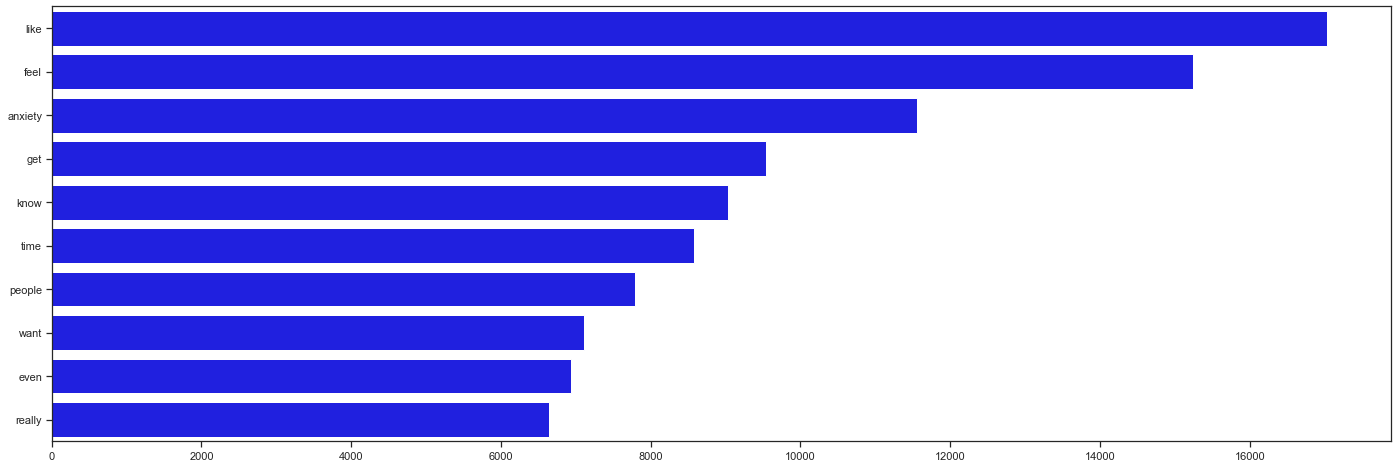

In [45]:
# plot common words in the frequency list

top_words = frequency.most_common(10)
top_words_df = pd.Series(dict(top_words))

plt.figure(figsize = (24,8))

sns.set_theme(style="ticks")
sns.barplot(y=top_words_df.index, x=top_words_df.values, color='blue')

plt.show()

### Polarity for Preprocessed Text with removal

In [47]:
# Sentiment Analysis Analyzer

from nltk.sentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

df['polarity'] = df['preprocessed-text-removal'].apply(lambda x: analyzer.polarity_scores(x))

df.head()

,text,preprocessed-text,preprocessed-text-removal,tokens,polarity
0,the reason i love alcohol at it makes me feel...,reason love alcohol make feel numb numb real r...,reason love alcohol make feel numb numb real r...,"[reason, love, alcohol, make, feel, numb, numb...","{'neg': 0.338, 'neu': 0.516, 'pos': 0.146, 'co..."
1,work-related anxiety depression,work related anxiety depression,work related anxiety depression,"[work, related, anxiety, depression]","{'neg': 0.73, 'neu': 0.27, 'pos': 0.0, 'compou..."
2,lately i've been having some pretty serious an...,lately pretty serious anxiety depression work ...,lately pretty serious anxiety depression work ...,"[lately, pretty, serious, anxiety, depression,...","{'neg': 0.196, 'neu': 0.503, 'pos': 0.302, 'co..."
3,does anyone else feel like they don’t belong a...,anyone else feel like belong anywhere,anyone else feel like belong anywhere,"[anyone, else, feel, like, belong, anywhere]","{'neg': 0.0, 'neu': 0.667, 'pos': 0.333, 'comp..."
4,it does not matter who is around me or who i a...,matter around total stranger people love alway...,matter around total stranger people love alway...,"[matter, around, total, stranger, people, love...","{'neg': 0.23, 'neu': 0.461, 'pos': 0.309, 'com..."


In [48]:
# change polarity to seperate columns

df = pd.concat(
    [df.drop(['polarity'], axis=1), 
     df['polarity'].apply(pd.Series)], axis=1)

df.head()

,text,preprocessed-text,preprocessed-text-removal,tokens,neg,neu,pos,compound
0,the reason i love alcohol at it makes me feel...,reason love alcohol make feel numb numb real r...,reason love alcohol make feel numb numb real r...,"[reason, love, alcohol, make, feel, numb, numb...",0.338,0.516,0.146,-0.8154
1,work-related anxiety depression,work related anxiety depression,work related anxiety depression,"[work, related, anxiety, depression]",0.730,0.270,0.000,-0.6597
2,lately i've been having some pretty serious an...,lately pretty serious anxiety depression work ...,lately pretty serious anxiety depression work ...,"[lately, pretty, serious, anxiety, depression,...",0.196,0.503,0.302,0.5719
3,does anyone else feel like they don’t belong a...,anyone else feel like belong anywhere,anyone else feel like belong anywhere,"[anyone, else, feel, like, belong, anywhere]",0.000,0.667,0.333,0.3612
4,it does not matter who is around me or who i a...,matter around total stranger people love alway...,matter around total stranger people love alway...,"[matter, around, total, stranger, people, love...",0.230,0.461,0.309,0.7588


In [49]:
# change compound to sentiment

df['sentiment'] = df['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')

df.head()

,text,preprocessed-text,preprocessed-text-removal,tokens,neg,neu,pos,compound,sentiment
0,the reason i love alcohol at it makes me feel...,reason love alcohol make feel numb numb real r...,reason love alcohol make feel numb numb real r...,"[reason, love, alcohol, make, feel, numb, numb...",0.338,0.516,0.146,-0.8154,negative
1,work-related anxiety depression,work related anxiety depression,work related anxiety depression,"[work, related, anxiety, depression]",0.730,0.270,0.000,-0.6597,negative
2,lately i've been having some pretty serious an...,lately pretty serious anxiety depression work ...,lately pretty serious anxiety depression work ...,"[lately, pretty, serious, anxiety, depression,...",0.196,0.503,0.302,0.5719,positive
3,does anyone else feel like they don’t belong a...,anyone else feel like belong anywhere,anyone else feel like belong anywhere,"[anyone, else, feel, like, belong, anywhere]",0.000,0.667,0.333,0.3612,positive
4,it does not matter who is around me or who i a...,matter around total stranger people love alway...,matter around total stranger people love alway...,"[matter, around, total, stranger, people, love...",0.230,0.461,0.309,0.7588,positive


In [51]:
print(df['sentiment'].value_counts())

sentiment
negative    13953
positive     9320
neutral      6314
Name: count, dtype: int64


### Polarity for Preprocessed Text (without removal)

In [52]:
df['polarity_without_removal'] = df['preprocessed-text'].apply(lambda x: analyzer.polarity_scores(x))

df.head()

,text,preprocessed-text,preprocessed-text-removal,tokens,neg,neu,pos,compound,sentiment,polarity_without_removal
0,the reason i love alcohol at it makes me feel...,reason love alcohol make feel numb numb real r...,reason love alcohol make feel numb numb real r...,"[reason, love, alcohol, make, feel, numb, numb...",0.338,0.516,0.146,-0.8154,negative,"{'neg': 0.33, 'neu': 0.528, 'pos': 0.142, 'com..."
1,work-related anxiety depression,work related anxiety depression,work related anxiety depression,"[work, related, anxiety, depression]",0.730,0.270,0.000,-0.6597,negative,"{'neg': 0.73, 'neu': 0.27, 'pos': 0.0, 'compou..."
2,lately i've been having some pretty serious an...,lately pretty serious anxiety depression work ...,lately pretty serious anxiety depression work ...,"[lately, pretty, serious, anxiety, depression,...",0.196,0.503,0.302,0.5719,positive,"{'neg': 0.196, 'neu': 0.503, 'pos': 0.302, 'co..."
3,does anyone else feel like they don’t belong a...,anyone else feel like belong anywhere,anyone else feel like belong anywhere,"[anyone, else, feel, like, belong, anywhere]",0.000,0.667,0.333,0.3612,positive,"{'neg': 0.0, 'neu': 0.667, 'pos': 0.333, 'comp..."
4,it does not matter who is around me or who i a...,matter around total stranger people love alway...,matter around total stranger people love alway...,"[matter, around, total, stranger, people, love...",0.230,0.461,0.309,0.7588,positive,"{'neg': 0.228, 'neu': 0.466, 'pos': 0.306, 'co..."


In [53]:
# change polarity_without_removal to seperate columns

df = pd.concat(
    [df.drop(['polarity_without_removal','neg','neu','pos','compound'], axis=1), 
     df['polarity_without_removal'].apply(pd.Series)], axis=1)

df.head()

,text,preprocessed-text,preprocessed-text-removal,tokens,sentiment,neg,neu,pos,compound
0,the reason i love alcohol at it makes me feel...,reason love alcohol make feel numb numb real r...,reason love alcohol make feel numb numb real r...,"[reason, love, alcohol, make, feel, numb, numb...",negative,0.330,0.528,0.142,-0.8154
1,work-related anxiety depression,work related anxiety depression,work related anxiety depression,"[work, related, anxiety, depression]",negative,0.730,0.270,0.000,-0.6597
2,lately i've been having some pretty serious an...,lately pretty serious anxiety depression work ...,lately pretty serious anxiety depression work ...,"[lately, pretty, serious, anxiety, depression,...",positive,0.196,0.503,0.302,0.5719
3,does anyone else feel like they don’t belong a...,anyone else feel like belong anywhere,anyone else feel like belong anywhere,"[anyone, else, feel, like, belong, anywhere]",positive,0.000,0.667,0.333,0.3612
4,it does not matter who is around me or who i a...,matter around total stranger people love alway...,matter around total stranger people love alway...,"[matter, around, total, stranger, people, love...",positive,0.228,0.466,0.306,0.7588


In [54]:
# change compound to sentiment_without_removal

df['sentiment_without_removal'] = df['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')
df = df.drop(['neg','neu','pos','compound'], axis=1)

df.head()

,text,preprocessed-text,preprocessed-text-removal,tokens,sentiment,sentiment_without_removal
0,the reason i love alcohol at it makes me feel...,reason love alcohol make feel numb numb real r...,reason love alcohol make feel numb numb real r...,"[reason, love, alcohol, make, feel, numb, numb...",negative,negative
1,work-related anxiety depression,work related anxiety depression,work related anxiety depression,"[work, related, anxiety, depression]",negative,negative
2,lately i've been having some pretty serious an...,lately pretty serious anxiety depression work ...,lately pretty serious anxiety depression work ...,"[lately, pretty, serious, anxiety, depression,...",positive,positive
3,does anyone else feel like they don’t belong a...,anyone else feel like belong anywhere,anyone else feel like belong anywhere,"[anyone, else, feel, like, belong, anywhere]",positive,positive
4,it does not matter who is around me or who i a...,matter around total stranger people love alway...,matter around total stranger people love alway...,"[matter, around, total, stranger, people, love...",positive,positive


In [55]:
print(df['sentiment_without_removal'].value_counts())

sentiment_without_removal
negative    13986
positive     9313
neutral      6288
Name: count, dtype: int64


### Polarity for Original Text

In [56]:
df['polarity_original'] = df['text'].apply(lambda x: analyzer.polarity_scores(x))

df.head()

,text,preprocessed-text,preprocessed-text-removal,tokens,sentiment,sentiment_without_removal,polarity_original
0,the reason i love alcohol at it makes me feel...,reason love alcohol make feel numb numb real r...,reason love alcohol make feel numb numb real r...,"[reason, love, alcohol, make, feel, numb, numb...",negative,negative,"{'neg': 0.223, 'neu': 0.713, 'pos': 0.064, 'co..."
1,work-related anxiety depression,work related anxiety depression,work related anxiety depression,"[work, related, anxiety, depression]",negative,negative,"{'neg': 0.844, 'neu': 0.156, 'pos': 0.0, 'comp..."
2,lately i've been having some pretty serious an...,lately pretty serious anxiety depression work ...,lately pretty serious anxiety depression work ...,"[lately, pretty, serious, anxiety, depression,...",positive,positive,"{'neg': 0.094, 'neu': 0.786, 'pos': 0.12, 'com..."
3,does anyone else feel like they don’t belong a...,anyone else feel like belong anywhere,anyone else feel like belong anywhere,"[anyone, else, feel, like, belong, anywhere]",positive,positive,"{'neg': 0.0, 'neu': 0.762, 'pos': 0.238, 'comp..."
4,it does not matter who is around me or who i a...,matter around total stranger people love alway...,matter around total stranger people love alway...,"[matter, around, total, stranger, people, love...",positive,positive,"{'neg': 0.163, 'neu': 0.682, 'pos': 0.155, 'co..."


In [57]:
# change polarity_original to seperate columns

df = pd.concat(
    [df.drop(['polarity_original'], axis=1), 
     df['polarity_original'].apply(pd.Series)], axis=1)

df.head()

,text,preprocessed-text,preprocessed-text-removal,tokens,sentiment,sentiment_without_removal,neg,neu,pos,compound
0,the reason i love alcohol at it makes me feel...,reason love alcohol make feel numb numb real r...,reason love alcohol make feel numb numb real r...,"[reason, love, alcohol, make, feel, numb, numb...",negative,negative,0.223,0.713,0.064,-0.8591
1,work-related anxiety depression,work related anxiety depression,work related anxiety depression,"[work, related, anxiety, depression]",negative,negative,0.844,0.156,0.000,-0.6597
2,lately i've been having some pretty serious an...,lately pretty serious anxiety depression work ...,lately pretty serious anxiety depression work ...,"[lately, pretty, serious, anxiety, depression,...",positive,positive,0.094,0.786,0.120,0.2846
3,does anyone else feel like they don’t belong a...,anyone else feel like belong anywhere,anyone else feel like belong anywhere,"[anyone, else, feel, like, belong, anywhere]",positive,positive,0.000,0.762,0.238,0.3612
4,it does not matter who is around me or who i a...,matter around total stranger people love alway...,matter around total stranger people love alway...,"[matter, around, total, stranger, people, love...",positive,positive,0.163,0.682,0.155,-0.6651


In [58]:
# change compound to sentiment_original

df['sentiment_original'] = df['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')
df = df.drop(['neg','neu','pos','compound'], axis=1)

df.head()

,text,preprocessed-text,preprocessed-text-removal,tokens,sentiment,sentiment_without_removal,sentiment_original
0,the reason i love alcohol at it makes me feel...,reason love alcohol make feel numb numb real r...,reason love alcohol make feel numb numb real r...,"[reason, love, alcohol, make, feel, numb, numb...",negative,negative,negative
1,work-related anxiety depression,work related anxiety depression,work related anxiety depression,"[work, related, anxiety, depression]",negative,negative,negative
2,lately i've been having some pretty serious an...,lately pretty serious anxiety depression work ...,lately pretty serious anxiety depression work ...,"[lately, pretty, serious, anxiety, depression,...",positive,positive,positive
3,does anyone else feel like they don’t belong a...,anyone else feel like belong anywhere,anyone else feel like belong anywhere,"[anyone, else, feel, like, belong, anywhere]",positive,positive,positive
4,it does not matter who is around me or who i a...,matter around total stranger people love alway...,matter around total stranger people love alway...,"[matter, around, total, stranger, people, love...",positive,positive,negative


In [59]:
print(df['sentiment_original'].value_counts())

sentiment_original
negative    14607
positive     8669
neutral      6311
Name: count, dtype: int64


We will use the original text polarity since it retains most of the meaning and has the highest percentage of negative comments since they are scraped mostly from mental disorder pages.